Lung histopathology

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
#from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_set= '/content/drive/MyDrive/lung_image_sets'

In [5]:
for i,d in enumerate([image_set]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)                   
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([lung_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

lung_scc    5000
lung_n      5000
lung_aca    5000
Name: labels, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_split=.6
test_split=.2
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  9000  _test_df length:  3000   valid_df length:  3000


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_set=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_set=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
validate_set=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
#classes=list(train_gen.class_indices.keys())
#class_count=len(classes)

test batch size:  75   test steps:  40
Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [9]:
IMAGE_SIZE = [224, 224]

In [10]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [11]:
inception = tf.keras.applications.InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 4s 0us/step


In [12]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [13]:
flatten = Flatten()(inception.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)

In [14]:
#creating a model
model = Model(inputs = inception.input, outputs = prediction )

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
# COMPILING THE MODEL

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [17]:
#executing the model
history = model.fit(train_set, validation_data = (validate_set), epochs = 30, verbose = 1)

Epoch 1/30
282/282 [==============================] - 4143s 15s/step - loss: 0.8742 - accuracy: 0.9048 - val_loss: 0.2604 - val_accuracy: 0.9253
Epoch 2/30
282/282 [==============================] - 126s 448ms/step - loss: 0.1332 - accuracy: 0.9598 - val_loss: 0.1205 - val_accuracy: 0.9600
Epoch 3/30
282/282 [==============================] - 127s 451ms/step - loss: 0.0621 - accuracy: 0.9783 - val_loss: 0.0921 - val_accuracy: 0.9723
Epoch 4/30
282/282 [==============================] - 127s 451ms/step - loss: 0.0771 - accuracy: 0.9777 - val_loss: 0.3203 - val_accuracy: 0.9260
Epoch 5/30
282/282 [==============================] - 127s 450ms/step - loss: 0.0645 - accuracy: 0.9806 - val_loss: 0.0975 - val_accuracy: 0.9683
Epoch 6/30
282/282 [==============================] - 127s 451ms/step - loss: 0.0160 - accuracy: 0.9942 - val_loss: 0.1109 - val_accuracy: 0.9680
Epoch 7/30
282/282 [==============================] - 127s 451ms/step - loss: 0.0380 - accuracy: 0.9869 - val_loss: 0.3537 - 

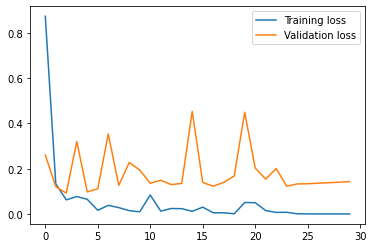

In [18]:
# plotting the loss
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
#plt.title('loss')
plt.legend()
plt.show()

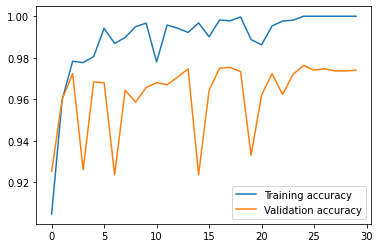

In [19]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
#plt.title('Accuracy')
plt.legend()
plt.show()

In [20]:
# CHECKING THE CONFUSION MATRIX

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)


40/40 [==============================] - 908s 23s/step


In [21]:
preds = model.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

40/40 [==============================] - 33s 832ms/step


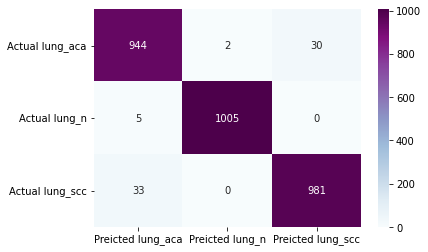

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1,2]), index=['Actual lung_aca','Actual lung_n','Actual lung_scc'],columns=['Preicted lung_aca','Preicted lung_n','Preicted lung_scc'])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="BuPu")

In [23]:
print('Classification Report')
target_names = ['lung_aca','lung_n','lung_scc']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    lung_aca       0.96      0.97      0.96       976
      lung_n       1.00      1.00      1.00      1010
    lung_scc       0.97      0.97      0.97      1014

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [24]:
loss, acc = model.evaluate_generator(test_set, len(test_set))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test_set.reset()

<ipython-input-24-9a3d6d22a8aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_set, len(test_set))






Loss: 0.16301211714744568
Accuracy: 97.67 %






In [25]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

40/40 [==============================] - 34s 856ms/step - loss: 0.1630 - accuracy: 0.9767
test_loss, test accuracy [0.16301211714744568, 0.9766666889190674]


In [26]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model.predict_generator(validation_generator, nb_validation_samples // 
#batch_size+1)
y_pred = np.argmax(preds, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

Confusion Matrix
[[ 944    2   30]
 [   5 1005    0]
 [  33    0  981]]
